## Experiential Task 2
Publicly traded companies announce earnings four times per year. These quarterly announcements convey significant information to the market about the company's performance as well as expectations about performance in the coming period. While Wall Street often focuses on whether earnings-per-share (EPS) "meets or beats" expectations, this metric represents only one data point in the announcement.

Managers supplement announced earnings with a detailed narrative disclosure which provides information helpful for interpreting performance. In this task, we will analyze these narrative disclosures using a few different machine learning approaches. Specifically: 

- We will apply topic modeling to understand the type of language in earnings announcements. 
- We will use Lasso regression to evaluate which topics best predict stock returns.
- We will train a discrete classifier to understand whether earnings announcements can be used to predict large positive returns.

This task will proceed in four general steps:
1. Load the data, pre-process, and extract features needed for our machine learning procedures (20% of grade).
2. Apply LDA to the corpus and inspect the top 5 words associated with each topic (30% of grade).
3. Use Lasso Regression to evaluate which topics most strongly predict stock returns (25% of grade).
4. Use a classifier of your choice to model the extent to which topics or words (your choice) most strongly predict large positive returns (>5% over 3-day period) (25% of grade).

Let's get started!

### Step 1: Prepare the Data
In this step, you should do the following:
1. Load the dataset using pandas. Confirm there are 12,500 rows.
2. Write a function that replaces any financial number with "financial_number. Then the function should filter out "bad" sentences, defined as those with fewer than 5 tokens OR more than 50% financial numbers. 
3. Generate a document term matrix which allows for single words and bigrams. Restrict tokens to only those that are all letters ("alpha") and at least 3 characters, but make sure to allow for "financial_number". Retain the 1,000 most common features, exclude english stop words, and exclude tokens appearing in more than 50% of documents.

#### 1.1 - Load the dataset (ExpTask2Data.csv.gz)
Use pandas to load the dataset, "ExpTask2Data.csv.gz", into a dataframe. Confirm you have 12,500 rows.

In [3]:
import pandas as pd 

In [ ]:
# Insert code to load the dataset into a dataframe called "df"
df = pd.read_csv('ExpTask2Data.csv.gz', compression='gzip')
assert len(df) == 12500

In [ ]:
df

#### 1.2 - Clean out the "bad" sentences
Fill in the following function based on the criteria given above. I recommend taking the following approach (and I have sketched out a function you can update) but you are free to handle this part of the task as you wish:
- Generate a list of sentences with `sent_tokenize`
- Loop over each sentence
- Identify financial numbers with a regular expression, and replace those with "financial_number".
- Tokenize words in the sentence with `word_tokenize`, and filter out non-alpha or non-"financial_number". Retain good tokens in `good_tokens`.
- Evaluate sentence per the parameters above (5 or more tokens, no more than 50% financial numbers)

In [ ]:
def calculate_percentage(sentence):
    total_tokens = len(sentence)
    if total_tokens == 0:
        return 0.0
    financial_number_count = sum(1 for token in sentence if token=="financial_number")
    return financial_number_count / total_tokens

In [ ]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize

def clean_sentences(txt):
    # add regular expression to "..." to clean out financial numbers:
    financial_pattern = r'[-+]?\$\d{1,4}(?:,?\d{3})*(?:\.\d{1,2})?(?:%|M|B|K)?'
    clean_txt = re.sub(financial_pattern," financial_number ",txt) 

    good_sents = []
    for sent in sent_tokenize(clean_txt): # generate list of sentences with sent_tokenize and loop over each sentence
        good_tokens = []
        for word in word_tokenize(sent):                
            # add code to apply logic above, building list of "good tokens"
            if not (word.isalpha() or word == 'financial_number'):
                continue
            else:
                good_tokens.append(word.lower())
        good_sents.append(good_tokens)
        
        # Now add logic to check if there are sufficient tokens to keep the sentence:
    good_sents = [s for s in good_sents if len(s)>=5] # at least 5 tokens in sentence  
    good_sents = [s for s in good_sents if calculate_percentage(s)<=.5] # less than 50% financial_number
    flat_list = [item if isinstance(item, str) else " ".join(item) for item in good_sents]
        
    
    return " ".join(flat_list)        
    #return good_sents

Now apply this function to the earnings announcement text ("ea_text"), placing the result in a new dataframe column called "clean_sent" (this will likely take 15-20 minutes, so you may want test your function on a smaller sample before applying to the full dataframe).

In [ ]:
test_ex = df.loc[0, 'ea_text'] 
clean_sentences(test_ex)

In [ ]:
df['clean_sent'] = df['ea_text'].apply(clean_sentences)

Before we generate the document term matrix, I'd recommend saving this dataframe so you don't have to re-run that code when continuing:

In [ ]:
# To save:
df.to_csv("./task2_data_clean.csv.gz",index=False)

In [4]:
# To load:
df = pd.read_csv("./task2_data_clean.csv.gz")

In [ ]:
df

#### Step 1.3
Now we will generate our document term matrix. Note that you need use `CountVectorizer` since we are going to use LDA. I've provided you the token pattern that will allow financial_number as a single token.

In [5]:
import spacy
nlp = spacy.load('en_core_web_lg')
import numpy as np
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stops = stopwords.words('english')

# Update with parameters needed per instructions; I've provided a token_pattern
vec = CountVectorizer(token_pattern = r'\b[a-zA-Z_]{3,}[a-zA-Z]*\b', # DO NOT REMOVE THIS LINE!!!!!!!!!
                      max_df=0.5,
                      lowercase=True, 
                      stop_words=list(stops), 
                      max_features=1000, ngram_range=(1,2)) 
dtm = vec.fit_transform(df['clean_sent'])

/home/hice1/ltobin7/.local/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_lg' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Step 2: Fitting the LDA Model
Next, we're going to generate topics from our document term matrix using LDA. We'll do this step in four parts:
1. Fitting LDA model over a range of topics
2. Evaluating diagnostics to select "best" choice
3. Fit a final model and generate topic scores
4. Evaluate top 5 words in each topic

#### 2.1 - Tuning LDA
As in demo 5A, I suggest using `sklearn`'s implementation of LDA, which is the best option for generating topical relevance at the document level. We need to do a little tuning for our model. I recommend doing this on a smaller sample of 5,000 records to save time. You should try between 40 and 150 topics, counting by 10s. You should set `topic_word_prior` equal to 0.15 and `doc_topic_prior` to 25 divided by the number of topics. Finally, we will use the coherence score, `u_mass`, as in demo 5A to evaluate topic quality. 

I've set up a tuning loop for you to use. Fill in the code as needed:

In [6]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np

# Select a sample of 5000 for training; use random_state=123
sample = pd.DataFrame(dtm.todense()).sample(5000,random_state=123)

# Set up "vocab", a list of feature names
#vocab = ...
vocab = np.array(vec.get_feature_names_out())

In [8]:
# Set up empty list to collect diagnostics
records = []
#for top in range(...): 
for top in range(40, 151, 10):
    print(f"Fitting {top} topics")
    record = {'topics':top}
    # Fill in missing parameters
    lda = LDA(n_components=top,
              doc_topic_prior=25/top,
              topic_word_prior=0.15,
              n_jobs = -1,
              random_state=123)

     # Add code to fit the the model
    lda.fit(sample)
    
    ## Add code to compute umass, add mean umass to "record", and collect record in list
    umass = metric_coherence_gensim(measure = "u_mass",
                        top_n = 5,
                        topic_word_distrib = lda.components_,
                        dtm = sample,
                        vocab = vocab,
                        texts = None) 
    record['mean_umass'] = np.mean(umass)
    records.append(record)

diagnostics = pd.DataFrame(records)

Fitting 40 topics
Fitting 50 topics
Fitting 60 topics
Fitting 70 topics
Fitting 80 topics
Fitting 90 topics
Fitting 100 topics
Fitting 110 topics
Fitting 120 topics
Fitting 130 topics
Fitting 140 topics
Fitting 150 topics


#### 2.2 - Evaluating `umass` and selecting number of topics for final model
In this step, you should plot `umass` over the range of topics ran in the previous step. Show your plot and then choose the optimum number of topics based on your plot. You are free to use whatever plotting approach you wish. 

In [7]:
import matplotlib.pyplot as plt

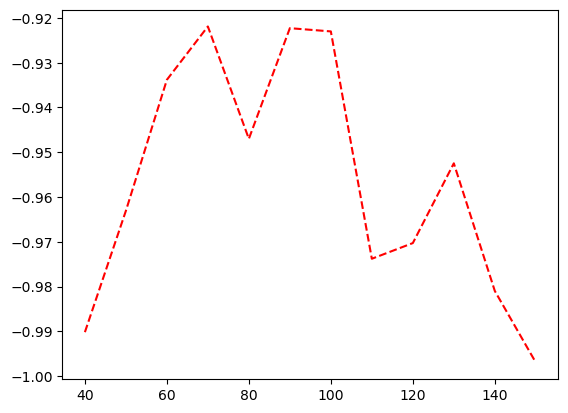

In [9]:
fig,ax = plt.subplots()
ax.plot(diagnostics['topics'],diagnostics['mean_umass'],color='red',linestyle='--')

**Interpret your plot and comment on the number of topics you plan to use:**

*My answer:* We want to choose the plot with the highest average Umass - in this example from the plot above, it looks like <font color='red'>70</font> topics is the optimal number (maybe a slight edge over 90 topics) so we will use that for our final model. 

#### Step 2.3
Now, fit a final LDA model using the number of topics chosen in the prior step and use it to transform the data.

In [10]:
chosen_topics = 70
# Set up final lda model:
final_lda = LDA(n_components=chosen_topics,
              doc_topic_prior=25/chosen_topics,
              topic_word_prior=0.15,
              n_jobs = -1,
              random_state=123)
# Fit final model and transform the DTM
topics = final_lda.fit_transform(dtm)

In [11]:
topics # view topics matrix

array([[0.00021513, 0.00388399, 0.00023639, ..., 0.00023933, 0.01427641,
        0.00134405],
       [0.00291993, 0.00065819, 0.00068452, ..., 0.00700787, 0.00068311,
        0.00064869],
       [0.0982059 , 0.00038921, 0.00049329, ..., 0.00040149, 0.00042315,
        0.00041792],
       ...,
       [0.00446809, 0.06343692, 0.00080555, ..., 0.00078129, 0.00082968,
        0.00077786],
       [0.01616234, 0.00113584, 0.00113766, ..., 0.00087597, 0.00091161,
        0.07197607],
       [0.00063744, 0.00065122, 0.0006819 , ..., 0.00096489, 0.02269592,
        0.00065235]])

#### 2.4 - Evaluate topic words
The final step in this part of the task is to evaluate the words in your topics. Word intrusion tasks are a good way to validate topics in an objective manner. We will not follow through on a full word intrusion task, but I would like you to display the top 5 words in each topic and a randomly chosen word from the vocabulary, separately identified as an intruder.

Fill in this code to generate the top 5 words in each topic plus an intruder:

In [12]:
def get_topic_words(topic,top_word,vocab,topn=5):
    top_words = top_word[topic,:].argsort()[-topn:][::-1].tolist()
    return vocab[top_words]

In [13]:
import random
topn = 5

# You need these two objects:
#vocab = ... NOTE: vocab is same as previously defined, so omitting this line 
top_word = final_lda.components_

# Insert code to perform the intrusion task
for top in range(chosen_topics):
    words = get_topic_words(top,top_word,vocab,topn=5)
    random_word = random.sample(list([w for w in vocab if w not in words]),1)[0]
    print(f"Topic {top} words: {'|'.join(words)}\t\tIntruder: {random_word}")

Topic 0 words: percent|increased percent|million percent|percent financial_number|percent compared		Intruder: income continuing
Topic 1 words: six|six months|half|million second|first half		Intruder: accrued liabilities
Topic 2 words: gas|oil|natural|production|natural gas		Intruder: contract
Topic 3 words: september|ended september|nine|nine months|september september		Intruder: reduced
Topic 4 words: continuing|continuing operations|discontinued|discontinued operations|loss continuing		Intruder: production
Topic 5 words: million first|net revenue|ended march|quarter compared|april		Intruder: excess
Topic 6 words: fiscal|fiscal year|tax rate|quarter fiscal|effective		Intruder: involve
Topic 7 words: health|care|attributable|ebitda|income attributable		Intruder: cents
Topic 8 words: underlying|pretax|volume|special|special items		Intruder: balance sheet
Topic 9 words: ebitda|adjusted ebitda|properties|transaction|totaled		Intruder: constant currency
Topic 10 words: fiscal|quarter fisca

### Step 3: Using Lasso to evaluate topic informativeness
In this portion of the task, you'll use Lasso regression to evaluate which topics exhibit the strongest associations with stock returns, which is labeled as "BHAR0_2" (or buy-and-hold abnormal returns from days 0 to 2). Note that this column is in percentage points (i.e., -4.5 indicates a return of -4.5%).

You should proceed as follows:
1. Identify the optimum out-of-sample value for `alpha` (the primary regularization parameter) using `RandomizedSearchCV`. You should try 100 random values in the range between 0.00001 and 0.02.
2. Analyze results of the best fit models. How many topics exhibit non-zero associations with returns? Which topic exhibits the strongest negative and positive associations (two total)?

#### 3.1 - Tuning the Lasso model
To tune the model, you first need do split your data into a training and testing sample. I've set most of this up for you; Replace `X` and `Y` with the datasets needed to conduct this test and update the function have a training sample of 80% and validation sample of 20%:

In [14]:
from sklearn.model_selection import train_test_split

Xtopic_train, Xtopic_test, Ytopic_train, Ytopic_test = train_test_split(topics, df['BHAR0_2'],train_size=0.8,random_state=123)

Next, you should set up your lasso model, parameter grid, and randomized searcher. Use these parameters for the search:
- <b>You parameter grid should include 100 random values for `alpha` between 0.00001 and 0.02. </b>
- <b>Your randomized search should run 50 times and use 5-fold cross-validation. </b>
- <b>You should use `neg_root_mean_squared_error` for scoring.</b>
- You should use `random_state=123` wherever possible.

Fill in the code below to set this up:

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso

np.random.seed(123)

param_grid = {'random_state':[123],
              'alpha':np.random.uniform(0.00001, 0.02, 100)}

lasso = Lasso()

rus = RandomizedSearchCV(lasso,param_grid,
                         scoring=['neg_root_mean_squared_error'],
                         n_iter=50,
                        # Update with rest of parameters
                        cv=5,
                        random_state = 123,
                        n_jobs = -1, # Optional
                        refit=False
                        )
rus.fit(Xtopic_train, Ytopic_train)

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': array([0.01393242, 0.00572993, 0.00454476, 0.01103078, 0.01439218,
       0.0084679 , 0.01961548, 0.01369975, 0.00962383, 0.00784843,
       0.00687013, 0.0145837 , 0.00877706, 0.00120296, 0.0079669 ,
       0.01476253, 0.00365801, 0.00351728, 0.01063571, 0.01064123,
       0.01269168, 0.01699014, 0.01449186, 0....
       0.01189269, 0.01114014, 0.0031876 , 0.00306988, 0.01391364,
       0.00638214, 0.01384249, 0.01109212, 0.00778512, 0.0185034 ,
       0.01683498, 0.00715438, 0.00088139, 0.00610231, 0.00796973,
       0.01410213, 0.01990722, 0.00712474, 0.01525333, 0.01186761,
       0.01383712, 0.00303104, 0.00798354, 0.00482471, 0.00687569]),
                                        'random_state': [123]},
                   random_state=123, refit=False,
                   scoring=['neg_root_mean_squared_error'])

To evaluate performance by `alpha`, prepare a scatter plot that shows the validation `neg_root_mean_squared_error` vs. `alpha` (**HINT**: results from the randomized search are in `rus.cv_results_`, which is a dictionary).

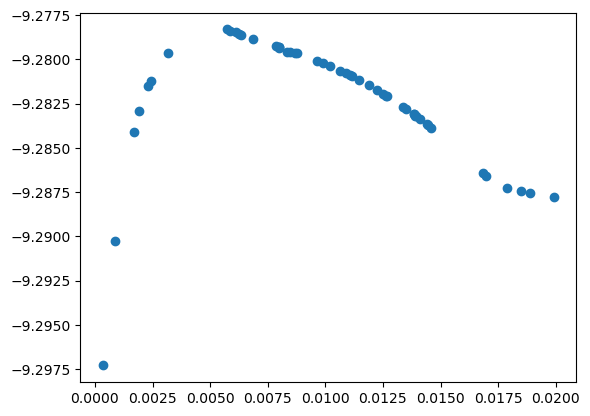

In [16]:
plt.scatter(rus.cv_results_['param_alpha'],rus.cv_results_['mean_test_neg_root_mean_squared_error'])

Now print the optimum value for `alpha`:

In [17]:
max_neg_mse = rus.cv_results_['mean_test_neg_root_mean_squared_error'].argmax()
print(f"The alpha that produces the minimum MSE is {rus.cv_results_['param_alpha'][max_neg_mse]}.")

The alpha that produces the minimum MSE is 0.005729925305658085.


#### 3.2 Interpreting Lasso results
To finish up this step, I'd like you to identify:

1. How many coefficients (each of which corresponds to a topic) are non-zero
2. Which topic has the most negative coefficient?
3. Which topic has the most positive coefficient?

Let's start with non-zero coefficients. Fill in the cell below to print out the number of coefficients not equal to zero:

In [18]:
# first must fit the lasso model with the optimal alpha
lasso = Lasso(alpha=rus.cv_results_['param_alpha'][max_neg_mse],
             random_state=123)
lasso.fit(Xtopic_train,Ytopic_train)

Lasso(alpha=0.005729925305658085, random_state=123)

In [19]:
#now print the total number of coefficients not equal to zero
len([c for c in lasso.coef_ if c!=0])

18

<b> Additional response to satisfy grading rubric: </b>There are <font color='red'>18</font> non-zero coefficients for the Lasso regression, hence according to the Lasso regression there are only 18 (of 70) topics that capture relevant predictions of stock returns. 

Now identify the most positive and most negative topics and print associated words (**HINT**: `argmax()` and `argmin()` make this very straightforward). 

Print out both the values of these coefficients and their indices:

In [20]:
most_pos = lasso.coef_.argmax()
most_neg = lasso.coef_.argmin()

print(f"The most positive coefficient corresponds to topic {most_pos} and has a value {lasso.coef_[most_pos]}.")
print(f"The most negative coefficient corresponds to topic {most_neg} and has a value {lasso.coef_[most_neg]}.")

The most positive coefficient corresponds to topic 40 and has a value 2.293208709204696.
The most negative coefficient corresponds to topic 65 and has a value -7.101443764662978.


Now, print the top 5 words corresponding to each of these two topics:

In [21]:
# Positive words:
words = get_topic_words(most_pos,top_word,vocab,topn=5)
print(f"Topic {most_pos} words: {'|'.join(words)}")

# Negative words:
words = get_topic_words(most_neg,top_word,vocab,topn=5)
print(f"Topic {most_neg} words: {'|'.join(words)}")

Topic 40 words: eps|free|free cash|diluted eps|adjusted operating
Topic 65 words: adjusted net|net loss|loss income|ebitda|income adjusted


**QUESTION**: Do you find this answer intuitive? Why or why not?

*INSERT ANSWER HERE*: Yes - these results do appear somewhat intuitive. EPS (earnings per share), free cash, diluted EPS, adjusted operating when discussing returns might relate to financial numbers might generally be positive values and will likely be mentioned strongly when the numbers are strong, improving, etc. On the flip side, the mentions of net loss, loss income are negative in sentiment just as is and EBITDA and income adjusted can take on negative values. Thus, it makes sense that the Lasso regression is picking up topic <font color='red'>40</font> as a positive predictor of stock returns and topic <font color='red'>65</font> as a negative predictor of stock returns. 

### Step 4: Use a classifier to predict large positive returns
The final part of this task is to use a classifier of your choice to predict large positive returns. You can use the document-term matrix or topic-matrix. You're also free to tune the model as you wish. Training classifiers can be time consuming, so I'm going to use an approach to this section called *specification grading*, meaning you can choose to omit parts of the process for a reduced grade.

Grading for this part will be done as follows:

1. Set up, train, and evaluate at least one classifier: If this portion is done perfectly and nothing else is done, you'll receive 50% credit for this part.
2. Apply robust tuning procedures to one or more models: If you tune multiple hyperparameters for the one model you fit in step 1, you'll receive an additional 10-20% (max grade 70%) credit, depending on extent of tuning. If you tune two or more models properly, this scale increases to 20-40% (max grade 90%).
3. Finally, the last 10% will be based on your best fit model. Specifically, using the validation data set up below, you should print your classification report. The best macro-F1 score in the class will receive 10% (100% cumulative) second best 9.5%, and so forth.

#### 4.1 - Data set-up an single model training
I'll help you set up the data so we all start from the same place. Note that I'm going to set up two sets of "X" data, one based on the DTM and the other on the topic matrix. You can use either (or both if you consider multiple models):

In [22]:
YLR = (df['BHAR0_2']>5).astype(int)
train_Xdtm, test_Xdtm, train_Xtopic, test_Xtopic, train_YLR, test_YLR = train_test_split(np.asarray(dtm.todense()),topics,YLR,train_size=0.80,random_state=123)

Next, you should fill in the cell below with code to train at least one model:

In [23]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix, classification_report
from lightgbm import LGBMClassifier as LGBM
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import SGDClassifier as SGD

In [24]:
# Train and evaluate at least one model
# For this first model, we will train a decision tree model 
tree = DTC(max_depth = 200, max_features = 'sqrt', random_state = 123)
tree.fit(train_Xdtm,train_YLR)

# evaluate the model on the test sample
print(classification_report(test_YLR,tree.predict(test_Xdtm)))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1904
           1       0.26      0.28      0.27       596

    accuracy                           0.64      2500
   macro avg       0.52      0.52      0.52      2500
weighted avg       0.65      0.64      0.65      2500



<b>Commentary:</b> This model appears to be biased - as we see large differences in precision, recall, F1-score for predicting the 0's vs. the 1's (i.e. lower returns vs. large positive returns). This is likely because we have many more 0's compared to 1's in the data so there is more information about the lower returns to be able to more accurately predict. 

In [25]:
# Since the model is biased, let's try to balance the weighting and see if that improves
tree = DTC(max_depth = 200, max_features = 'sqrt', random_state = 123, class_weight='balanced')
tree.fit(train_Xdtm,train_YLR)

# evaluate the model on the test sample
print(classification_report(test_YLR,tree.predict(test_Xdtm)))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1904
           1       0.24      0.25      0.24       596

    accuracy                           0.63      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.64      0.63      0.63      2500



<b>Commentary:</b> This appeared to worsen the model; let's revisit in the next section when tuning. 

#### 4.2 - Model Tuning
Here, you should insert code you use to tune your classifier. You can insert additional cells if needed, or skip this step and accept a lower grade if desired.

In [26]:
# Here I will go through many classification models and tuning hyperparamters before arriving at a final model 
np.random.seed(123)
maj_weight = np.random.uniform(0,0.5,50) # 50 random numbers between 0 and 0.5
class_weights = [{0: 1-k, 1:k} for k in maj_weight]
class_weights.append('balanced') # adds "balanced" as an option
class_weights.append(None) # adds no weighting as an option
class_weights[:10]

[{0: 0.6517654072010692, 1: 0.3482345927989308},
 {0: 0.8569303325248103, 1: 0.14306966747518973},
 {0: 0.8865742732178985, 1: 0.11342572678210155},
 {0: 0.7243426154585544, 1: 0.2756573845414456},
 {0: 0.6402655151072185, 1: 0.35973448489278154},
 {0: 0.7884467699377695, 1: 0.21155323006223048},
 {0: 0.5096179008076922, 1: 0.49038209919230774},
 {0: 0.6575851307075684, 1: 0.34241486929243165},
 {0: 0.7595340492578195, 1: 0.24046595074218047},
 {0: 0.8039412409029247, 1: 0.19605875909707526}]

In [27]:
dt_params = {'criterion':['gini','entropy','log_loss'],
             'max_depth':[None,10, 20, 50, 100],
             'min_samples_split':[2,5,10], # required to split
             'max_features':[None,'sqrt','log2'],
             'class_weight':class_weights,
             'random_state':[123]
            }

sgd_params = {'loss':['hinge','log_loss','modified_huber', 'squared_hinge', 'perceptron'],
              'penalty':['l1','l2','elasticnet',None], # elasticinet is another regularization technique that encourages sparsity
              'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
              'l1_ratio':np.random.uniform(0,1,10).tolist(),
              'random_state':[123],
              'class_weight':class_weights,
              'max_iter':[1000,2000]
             }     

rf_params = {'n_estimators':[10,25,50,100,200],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[None,10, 20, 50, 100],
             'min_samples_split':[2,5,10], # required to split
             'max_features':[None,'sqrt','log2'],
             'max_samples':[None,0.10,0.50,0.75],
             'class_weight':class_weights,
             'random_state':[123]
            }

#lgbm_params = {'boosting_type':['gbdt', 'dart', 'goss'],
#               'num_leaves':[10,20,30,40,50],
#               'max_depth':[-1, 10, 20, 50, 100],
#               'learning_rate':[0.01,0.1,0.2,0.5], # note this is a very important parameter, as it controls how much "feedback" the model has. You can also define a function to make it adaptive
#               'n_estimators':[25,50,75,100,200],
#               'class_weight':class_weights,
#               'random_state':[123]
#              }

In [28]:
final_mods = []
for mod,params in zip([DTC(),SGD(),RFC()],[dt_params, sgd_params, rf_params]): # zip creates a list of tuples we can use to iterate
    rand_search = RandomizedSearchCV(mod,params, # positional arguments, model and parameter grid
                                     n_iter=50,
                                     scoring='f1_macro', 
                                     cv=5,
                                     random_state=123,
                                     n_jobs=-1)
    
    rand_search.fit(train_Xdtm,train_YLR)
    print(f"Classification Report with hold-out sample for best fit of this model:...\n")
    print(type(mod))
    print(classification_report(test_YLR,rand_search.predict(test_Xdtm)))
    print("------------------------------------------------------")
    final_mods.append(rand_search)

Classification Report with hold-out sample for best fit of this model:...

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1904
           1       0.24      0.26      0.25       596

    accuracy                           0.63      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.64      0.63      0.63      2500

------------------------------------------------------


/storage/ice-shared/mgt8833/class_environment/ExpTask2/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/storage/ice-shared/mgt8833/class_environment/ExpTask2/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/storage/ice-shared/mgt8833/class_environment/ExpTask2/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/storage/ice-shared/mgt8833/class_environment/ExpTask2/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of 

Classification Report with hold-out sample for best fit of this model:...

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1904
           1       0.28      0.22      0.25       596

    accuracy                           0.68      2500
   macro avg       0.53      0.52      0.52      2500
weighted avg       0.65      0.68      0.67      2500

------------------------------------------------------
Classification Report with hold-out sample for best fit of this model:...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1904
           1       0.25      0.12      0.17       596

    accuracy                           0.70      2500
   macro avg       0.51      0.50      0.49      2500
weighted avg       0.64      0.70      0.66      2500

-----------------

#### 4.3 - Report final classification report
Here, you should report your final classification report:

In [29]:
print(f"Best estimator for Decision Tree: {final_mods[0].best_estimator_} \n\n\n")
rand_search = final_mods[0].best_estimator_
print(f"Classification report: {classification_report(test_YLR, rand_search.predict(test_Xdtm))}")
print("------------------------------------------------------")
print(f"Best estimator for Stochastic Gradient: {final_mods[1].best_estimator_} \n\n\n")
rand_search = final_mods[1].best_estimator_
print(f"Classification report: {classification_report(test_YLR, rand_search.predict(test_Xdtm))}")
print("------------------------------------------------------")
print(f"Best estimator for Random Forest: {final_mods[2].best_estimator_} \n\n\n")
rand_search = final_mods[2].best_estimator_
print(f"Classification report: {classification_report(test_YLR, rand_search.predict(test_Xdtm))}")
print("------------------------------------------------------")

Best estimator for Decision Tree: DecisionTreeClassifier(class_weight={0: 0.6517654072010692,
                                     1: 0.3482345927989308},
                       criterion='log_loss', max_features='log2',
                       random_state=123) 



Classification report:               precision    recall  f1-score   support

           0       0.76      0.74      0.75      1904
           1       0.24      0.26      0.25       596

    accuracy                           0.63      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.64      0.63      0.63      2500

------------------------------------------------------
Best estimator for Stochastic Gradient: SGDClassifier(alpha=0.5,
              class_weight={0: 0.7490816620578318, 1: 0.2509183379421683},
              l1_ratio=0.6813007657927966, loss='squared_hinge',
              penalty='elasticnet', random_state=123) 



Classification report:               precision    recall  f1-score

<b>Commentary:</b> <font color='red'>I spent many hours tuning - including for a LightGBM model, but no matter the parameters I set on the session (nodes, cores, memory), I could not get this to complete within 8 hours. So in this final version, I have dropped the attempts at tuning the LightGBM model. All of the tuning that did complete still did not show much improvement in the performance of the model. The best average macro F1 score was 52% for the SGD classifier model - but for the lower returns, the F1-score was 80% and large positive returns 25%. The model is biased - likely driven by the fact that there are many more lower returns in the data compared to high positiv5e returns. </font>